In [1]:
import cv2 as cv
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

<hr />

### ⦿ Enhancing

In [2]:
imgRaw = cv.imread("sunsetDrive.jpg")

Changes the channels so they are in the same order as the original image

In [3]:
imgOriginal = cv.cvtColor(imgRaw, cv.COLOR_BGR2RGB)

Function for easier plotting of the image and its respective intensity histogram

In [4]:
def plotImageWithIntensityHist(image, title):

    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
 
    cdf = hist.cumsum()
    cdfNorm = cdf * float(hist.max()) / cdf.max()
 
    fig, ax = plt.subplots(1, 2, figsize=(12.5,5))

    ax[0].imshow(image)

    ax[1].plot(cdfNorm)
    ax[1].hist(image.flatten(), 256, [0, 256])
    ax[1].legend(("CDF", "Histogram"), loc = "upper left")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

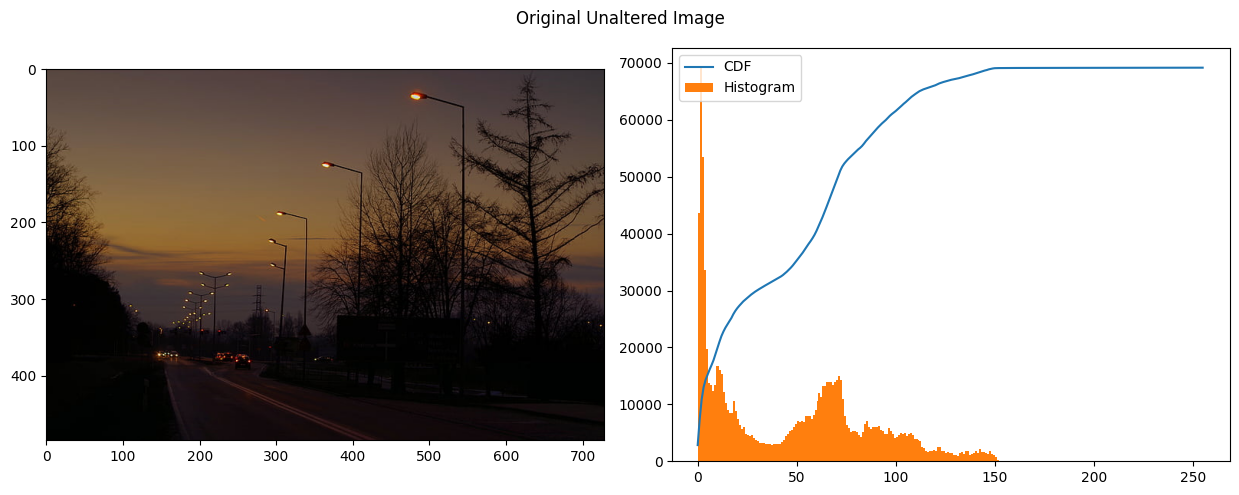

In [5]:
plotImageWithIntensityHist(imgOriginal, "Original Unaltered Image")

#### ◙ ◙ Histogram Equalization

##### Independent Equalization on All Channels

In [6]:
rgbChannels = cv.split(imgOriginal)

rgbChannelsEqualized = [cv.equalizeHist(ch) for ch in rgbChannels]
imgOriginal_Equalized = cv.merge(rgbChannelsEqualized)

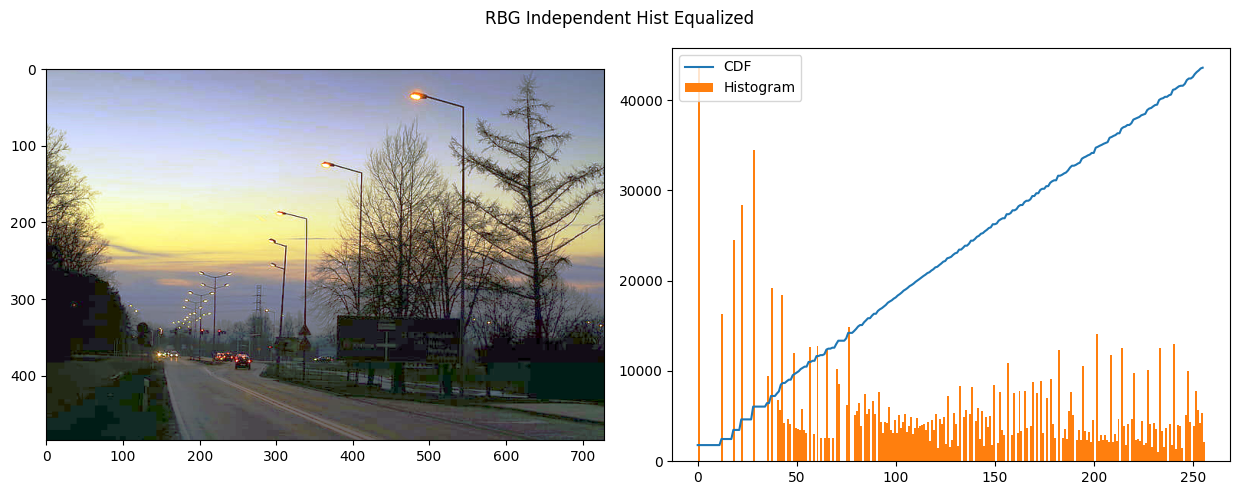

In [7]:
plotImageWithIntensityHist(imgOriginal_Equalized, "RBG Independent Hist Equalized")

##### Equalization on V Channel

In [8]:
imgHSV = cv.cvtColor(imgRaw, cv.COLOR_BGR2HSV)

In [9]:
h, s, v = cv.split(imgHSV)
vEqualized = cv.equalizeHist(v)
imgHSV = cv.merge([h, s, vEqualized])
imgEqualized_vChannel = cv.cvtColor(imgHSV, cv.COLOR_HSV2RGB)

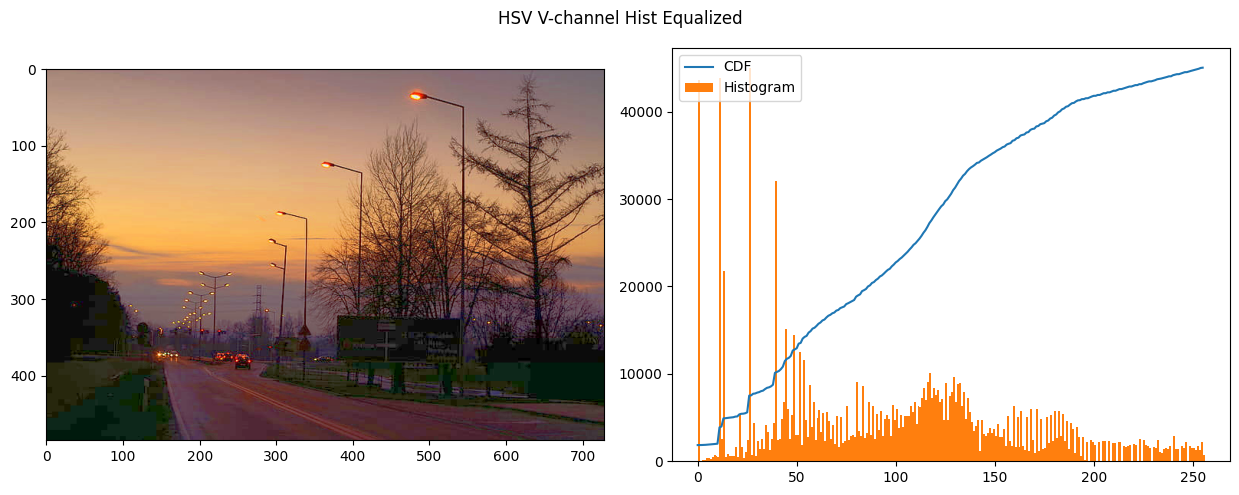

In [10]:
plotImageWithIntensityHist(imgEqualized_vChannel, "HSV V-channel Hist Equalized")

#### ◙ ◙ Gamma Enhancing

##### Low Intensity Areas (gamma > 1)

In [11]:
gamma = 2
table = np.array([(i / 255.0) ** (1 / gamma) * 255 for i in range(256)]).astype("uint8")

imgOriginal_LowIntEnhanced =  cv.LUT(imgOriginal, table)

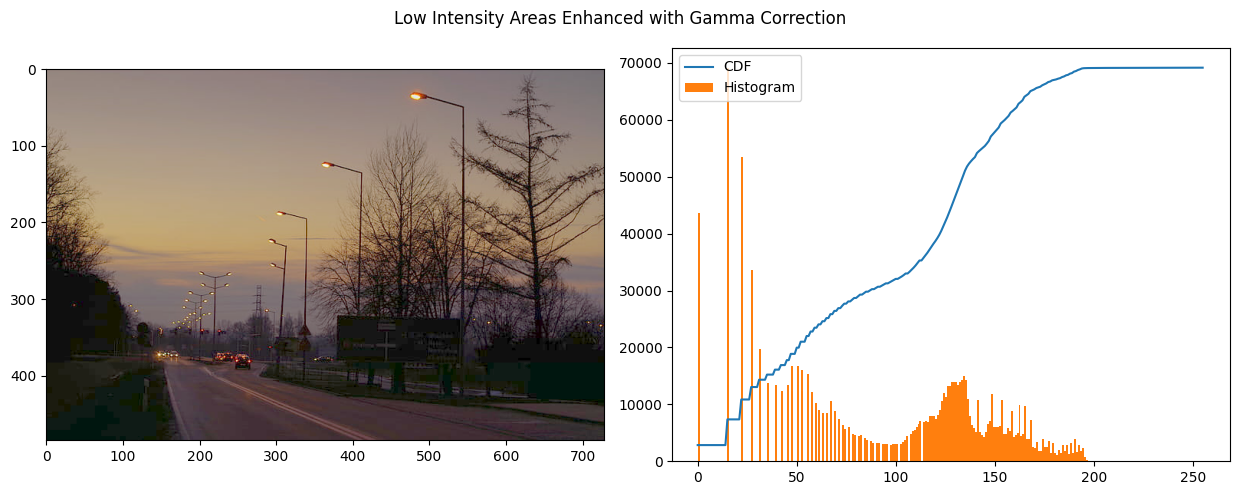

In [12]:
plotImageWithIntensityHist(imgOriginal_LowIntEnhanced, "Low Intensity Areas Enhanced with Gamma Correction")

##### High Intensity Areas (gamma \< 1)

In [13]:
gamma = 0.5
table = np.array([(i / 255.0) ** (1 / gamma) * 255 for i in range(256)]).astype("uint8")

imgOriginal_HighIntEnhanced =  cv.LUT(imgOriginal, table)

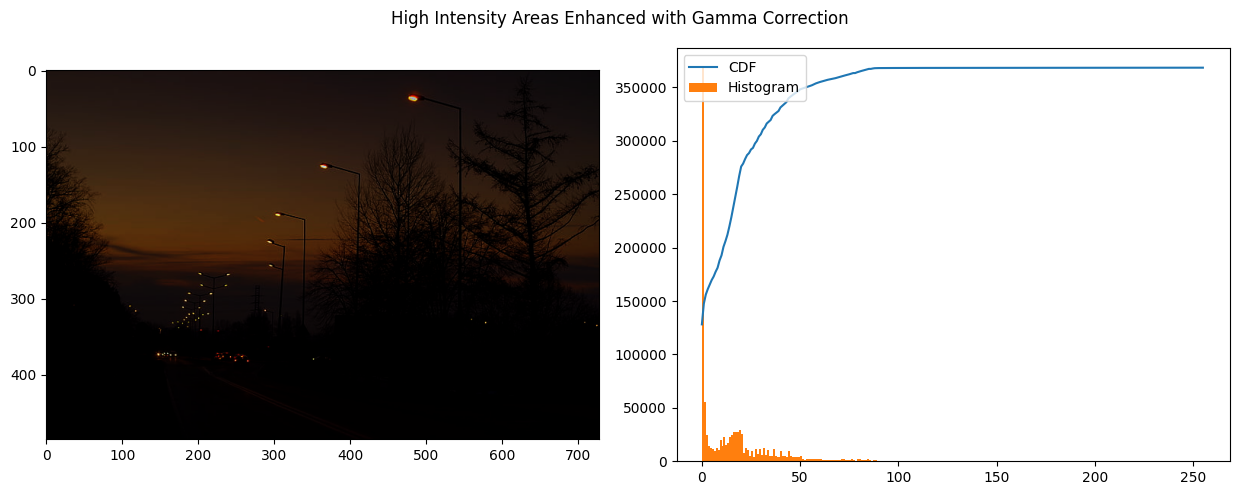

In [14]:
plotImageWithIntensityHist(imgOriginal_HighIntEnhanced, "High Intensity Areas Enhanced with Gamma Correction")

<hr />

### ⦿ Edge Detection

In [15]:
imgRaw = cv.imread("mclovin.jpg")

Changes the channels so they are in the same order as the original image

In [16]:
imgOriginal = cv.cvtColor(imgRaw, cv.COLOR_BGR2RGB)

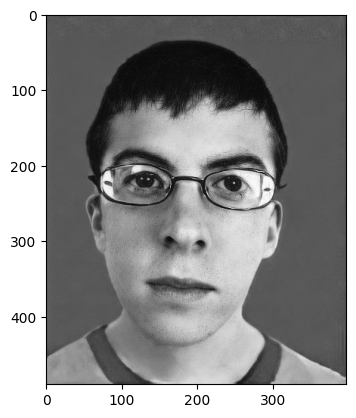

In [17]:
imgGrayscale = cv.cvtColor(imgOriginal, cv.COLOR_RGB2GRAY)
plt.imshow(imgGrayscale, cmap="gray")
plt.show()

#### ◙ ◙ Computation of the Gradient of Grayscale

Gradient is computed using Sobel Operator

In [18]:
gradHorizontal = cv.Sobel(imgGrayscale, cv.CV_64F, 1, 0, ksize=5)
gradVertical = cv.Sobel(imgGrayscale, cv.CV_64F, 0, 1, ksize=5)
gradBoth = cv.Sobel(imgGrayscale, cv.CV_64F, 1, 1, ksize=5)

gradEdgesDetected = np.abs(gradHorizontal) + np.abs(gradVertical)

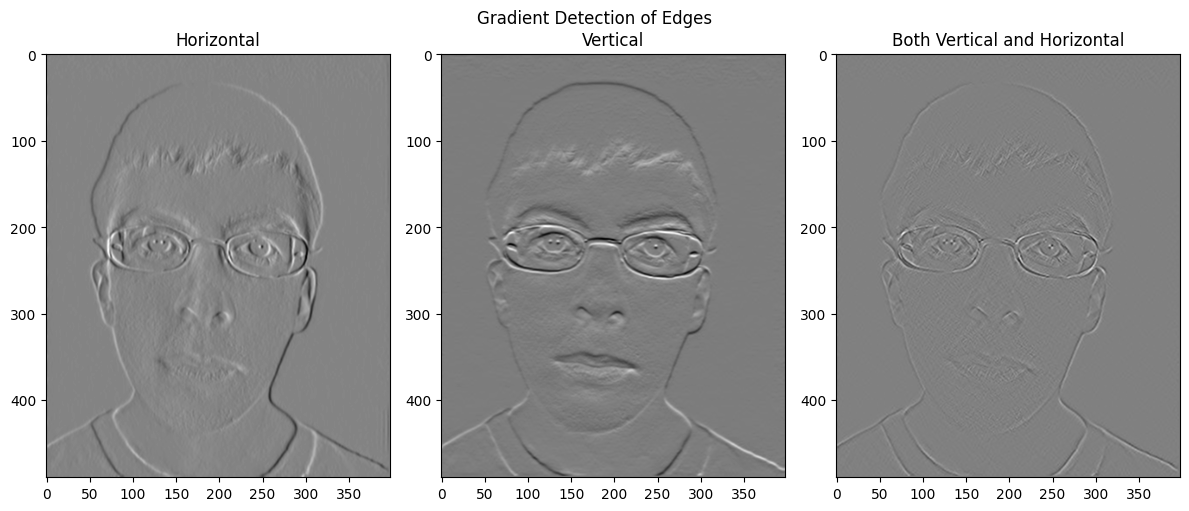

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Gradient Detection of Edges")

ax[0].imshow(gradHorizontal, cmap="gray")
ax[0].set_title("Horizontal")

ax[1].imshow(gradVertical, cmap="gray")
ax[1].set_title("Vertical")

ax[2].imshow(gradBoth, cmap="gray")
ax[2].set_title("Both Vertical and Horizontal")

plt.tight_layout()
plt.show()

Magnitude and angle are determined based on the gradient

In [20]:
magnitude = cv.magnitude(gradHorizontal, gradVertical)
magnitude = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
magnitude = magnitude.astype(np.uint8)

angle = cv.phase(gradHorizontal, gradVertical, angleInDegrees=True)
angle = cv.normalize(angle, None, 0, 255, cv.NORM_MINMAX)
angle = angle.astype(np.uint8)

In [21]:
r = magnitude
g = imgGrayscale
b = angle

gradCreatedImg = cv.merge((r,g,b))

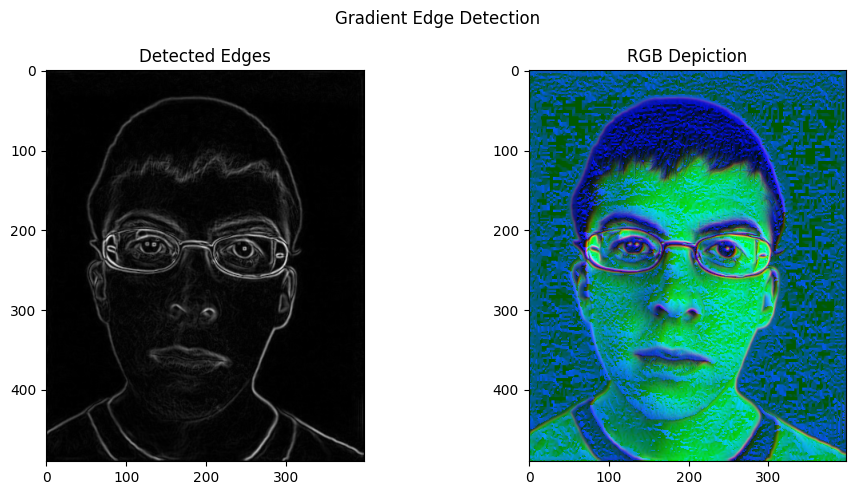

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Gradient Edge Detection")

ax[0].imshow(gradEdgesDetected, cmap="gray")
ax[0].set_title("Detected Edges")

ax[1].imshow(gradCreatedImg)
ax[1].set_title("RGB Depiction")

plt.tight_layout()
plt.show()

#### ◙ ◙ Localization of Edges using Laplacian (Zero-Crossing)

The kernel and threshold are the same as those used in class

In [23]:
kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) / 4.0
threshold = 2 * np.sqrt(np.var(gradEdgesDetected.flatten()))

laplacian = convolve2d(imgGrayscale, kernel, mode="same")

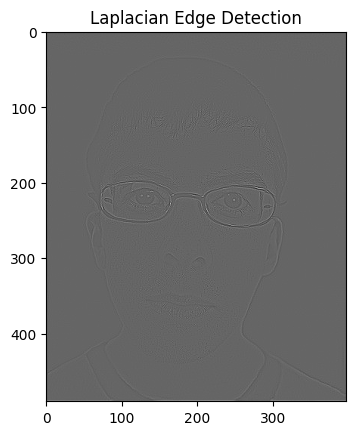

In [24]:
plt.imshow(laplacian, cmap="gray")
plt.title("Laplacian Edge Detection")
plt.show()

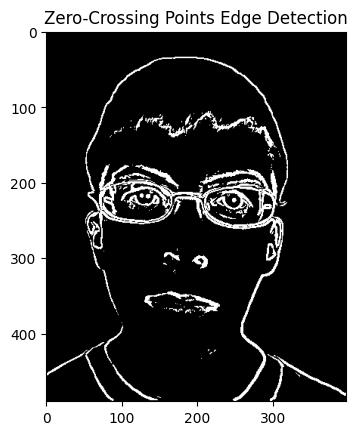

In [25]:
zeroCrossingImg = np.abs(laplacian) < 0.05 * threshold
zeroCrossingAtSobel = np.multiply(zeroCrossingImg, gradEdgesDetected > threshold)

plt.imshow(zeroCrossingAtSobel, cmap="gray")
plt.title("Zero-Crossing Points Edge Detection")
plt.show()

#### ◙ ◙ Computation of the Canny Edges

In [26]:
def computeCannyEdges(image, sigma):
    smoothedImg = cv.GaussianBlur(image, (0, 0), sigma)
    edges = cv.Canny(smoothedImg, 50, 150)
    return edges

In [27]:
sigmas = [0.5, 1.25, 2]
images_cannyEdges = [computeCannyEdges(imgGrayscale, sigma) for sigma in sigmas]

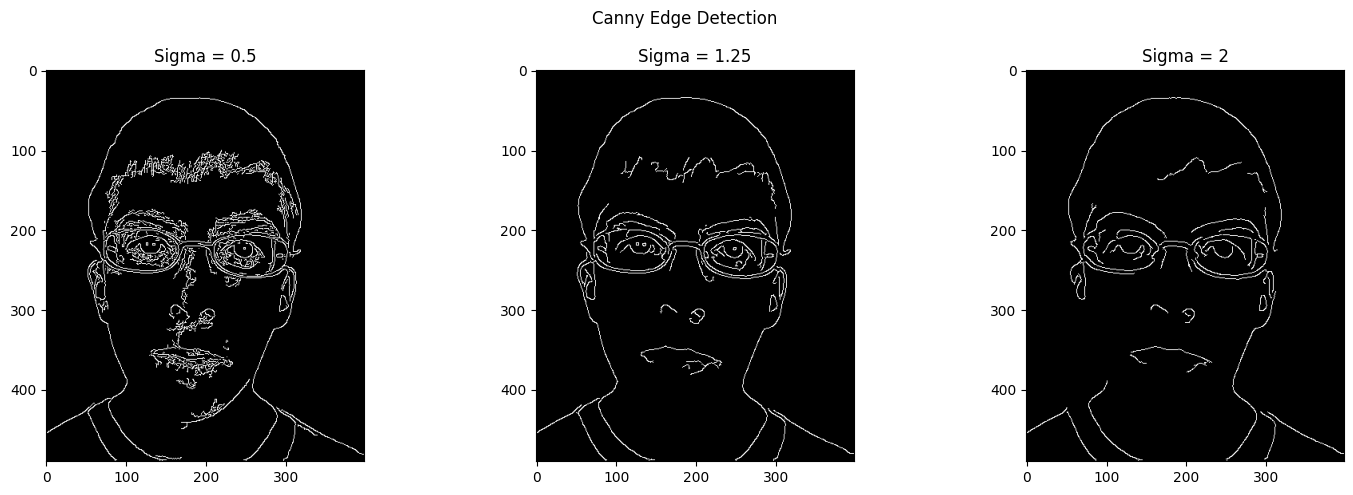

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (sigma, edges) in enumerate(zip(sigmas, images_cannyEdges)):
    ax[i].set_title(f"Sigma = {sigma}")
    ax[i].imshow(edges, cmap="gray")
    
plt.suptitle("Canny Edge Detection")
plt.tight_layout()
plt.show()